# Model for predicting Second Language Adquisiton

We start by loading the necessary libraries.

In [1]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
import pandas as pd
from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP as BLURR # lo importamos así para que sea compatible con el resto
from datasets import load_dataset, concatenate_datasets

/home/jonathan/.virtualenvs/huggingface/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import torch
torch.cuda.set_device(2)

Now, we load the train and validation sets.

In [3]:
train_df = pd.read_csv('perplejidad/datasets/train_train_set.csv',delimiter='\t')

In [4]:
train_df = train_df[train_df.Level=='B2']

In [5]:
valid_df = pd.read_csv('perplejidad/datasets/validation_train_set.csv',delimiter='\t')

In [6]:
valid_df = valid_df[valid_df.Level=='B2']

In [7]:
len(train_df),len(valid_df)

(4747, 527)

In [8]:
train_df['is_valid']=False

In [9]:
valid_df['is_valid']=True

In [10]:
train_valid_df = pd.concat([train_df,valid_df])

We define the indexes for training and validation.

In [11]:
train_idxs, valid_idxs = L(range(len(train_valid_df[train_valid_df.is_valid==False]))), L(range(len(train_valid_df[train_valid_df.is_valid==False]), len(train_valid_df)))

Now, we can define the model. In this case, we use a predefined model called Roberta.

In [12]:
dl_kwargs = {"bs": 96, "val_bs": 64}
learn_kwargs = {"metrics": [accuracy]}

In [13]:
learn = BlearnerForSequenceClassification.from_data(
    train_valid_df,
    "bertin-project/bertin-roberta-base-spanish",
    text_attr="Sentence",
    label_attr="Mother tongue",
    dblock_splitter=IndexSplitter(valid_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [14]:
learn = learn.to_fp16()

In [15]:
learn.dls.show_batch(dataloaders=learn.dls, trunc_at=500, max_n=5)

,text,target
0,"Mi nombre es Ricardo_Enrique_da_Silva_Elias, tengo 29 años, soy de Salvador_de_Bahia, Brasil, vengo através_de esta carta solicitar mi admisión en el programa de postgrado de lengua y literatura española de esta gran Universidad.",Portugués
1,"Me llamo Zesheng_Ma, me gradué de la Unviersidad_de_Estudios_Extranjeros_de_Pekín, China con título de lengua y literatura española en junio_de_2017 cumpliendo 4 años de estudio universitario en la carrera.",Chino mandarín
2,"Al_fin_y_a_el_cabo no estoy en_contra_de que se produzca el cigarrilo creo en la libertad que uno tiene de fumar si quieres, pero sí definitivamente, estoy en_contra_de que este lo haga en lugares públicos.",Portugués
3,"Yo soy a_favor_de mas campañas en_medio_de publicidades acerca_de el ato de no fumar en_general y que se debe mantener las prohibiciones de no humar en lugares públicos por los que no human, los niños y las embarazadas principalmente.",Portugués
4,"Para que este intento logre el éxito deseado, me gustaría, por primero, a presentar me a ustedes : me llamo Cláudio_Alves_do_Nascimento, tengo 48 años, soy divorciado y tengo un hijo de 17 años.",Portugués


In [16]:
learn.fine_tune(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.745687,1.745189,0.259962,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.730455,1.746945,0.278937,00:07
1,1.717926,1.684301,0.337761,00:07
2,1.696060,1.673888,0.343453,00:07
3,1.538072,1.492969,0.411765,00:07
4,1.275812,1.624241,0.440228,00:07
5,0.845771,2.055506,0.407970,00:07
6,0.442895,2.699080,0.415560,00:07
7,0.189398,3.495039,0.409867,00:07
8,0.077032,3.523327,0.423150,00:07
9,0.033546,3.524906,0.426945,00:07


In [17]:
# learn.export('roberta-mother-tonge-a1.pkl')

In [17]:
learn.save('roberta-mother-tonge-b2')

Path('models/roberta-mother-tonge-b2.pth')

In [40]:
test_df = pd.read_csv('perplejidad/datasets/test_set.csv',delimiter='\t')

In [41]:
test_df = test_df[test_df.Level=='A1']

In [42]:
test_df['is_valid']=True

In [43]:
train_test_df = pd.concat([train_df,test_df])

In [44]:
train_idxs, test_idxs = L(range(len(train_test_df[train_test_df.is_valid==False]))), L(range(len(train_test_df[train_test_df.is_valid==False]), len(train_test_df)))

In [45]:
learnTest = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "bertin-project/bertin-roberta-base-spanish",
    text_attr="Sentence",
    label_attr="Mother tongue",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [46]:
learnTest.load('roberta-mother-tonge-a1')

In [47]:
learnTest.validate()

(#2) [3.4958014488220215,0.5526636838912964]

In [48]:
from fastai.interpret import *

In [49]:
preds,gt=learnTest.get_preds()

In [50]:
len(preds)

2459

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [52]:
cm = confusion_matrix(gt, np.argmax(preds,axis=1))

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learn.dls.vocab)

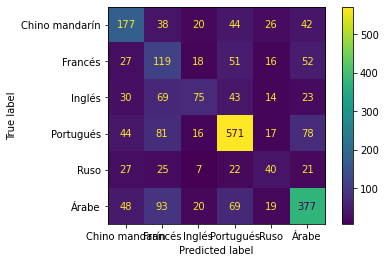

In [54]:
disp.plot()